<h1 align='center'>Business Forecasting

Client receives a lot of requests for its various finance offerings that include housing loans, two-wheeler loans, real estate financing, and microloans. The number of applications received is something that varies a lot with the season. Going through these applications is a manual and tedious process.

Goal is to forecast daily cases for the next 3 months for 2 different business segments aggregated at the country level keeping in consideration the following major Indian festivals

<b>Business segment 1</b> - historical data was made available at branch ID level.

<b>Business segment 2</b> - historical data was made available at the state level.

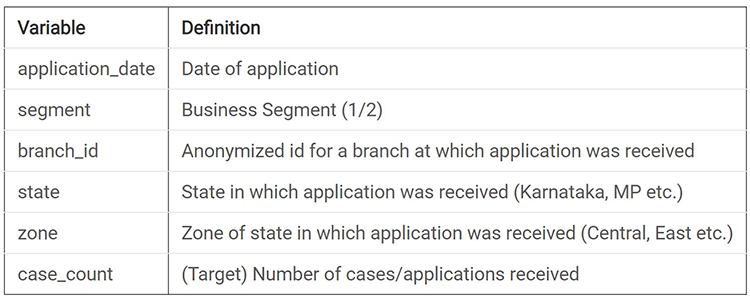

In [1]:
# !pip install pmdarima
# !pip install pandasql

In [2]:
import numpy as np
import pandas as pd

import pandasql as ps 

#Importing statsmodel Library - which helps in time series
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import normaltest

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy



#Importing Visualization lib files
from matplotlib import pyplot as plt

import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

#### Data Exploration:

In [3]:
#This for displaying the whole content of a dataframe:
pd.options.display.max_colwidth = 1000

In [4]:
Total_LoanApplicationTrain_df = pd.read_csv('Train.csv')

In [5]:
Total_LoanApplicationTrain_df.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [6]:
print("Train shape ",Total_LoanApplicationTrain_df.shape)

Train shape  (80402, 6)


<h3>Convert the columns to its respective data type:

In [7]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object and props[col].dtype.name !='category':  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
        
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
            
        else:
             props[col] = props[col].astype('category')
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [8]:
print("Train TYPE = ",Total_LoanApplicationTrain_df.dtypes)

Train TYPE =  application_date     object
segment               int64
branch_id           float64
state                object
zone                 object
case_count          float64
dtype: object


<h4> Converting the attributes to its respective types based on the space required.

In [9]:
def GetConvertedData(_data):
    props, NAlist = reduce_mem_usage(_data)
    print("_________________")
    print("")
    print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
    print("_________________")
    print("")
    print(NAlist)

In [10]:
GetConvertedData(Total_LoanApplicationTrain_df)

Memory usage of properties dataframe is : 3.680633544921875  MB
******************************
Column:  segment
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  branch_id
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  case_count
dtype before:  float64
dtype after:  uint16
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.7366733551025391  MB
This is  20.014851957183247 % of the initial size
_________________

_________________

['branch_id']


In [11]:
Total_LoanApplicationTrain_df['application_date'] = pd.to_datetime(Total_LoanApplicationTrain_df['application_date'], format='%Y-%m')

In [12]:
# Total null values in Train
print("Train = ",Total_LoanApplicationTrain_df.isnull().sum())

Train =  application_date        0
segment                 0
branch_id               0
state                   0
zone                13504
case_count              0
dtype: int64


#### Total Loan Application with respective to every state in india.

In [13]:
State_CaseCount_df = Total_LoanApplicationTrain_df[['state','case_count']]
State_CaseCount_df = pd.DataFrame(pd.Series(State_CaseCount_df.groupby('state')['case_count'].sum()))
State_CaseCount_df = State_CaseCount_df.reset_index()

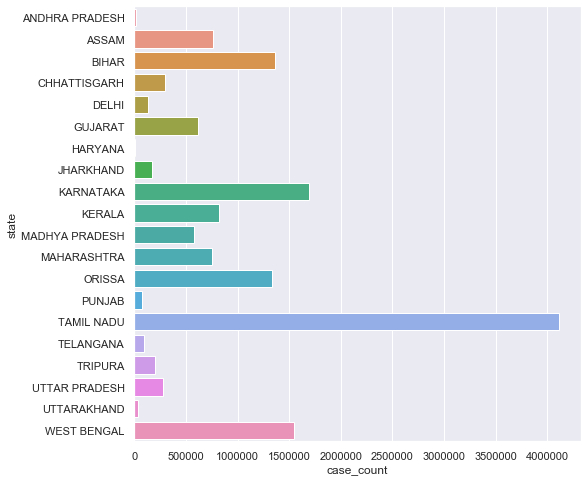

In [14]:
sns.set(rc={'figure.figsize':(8,8)})
plot = sns.barplot(x="case_count",y='state',data=State_CaseCount_df)

<h4>Currently the forecasting is done at  branch level for next 202 days by taking the indian holidays as a exogen variables

In [15]:
#taking only branch-id 13 for our analysis.
BranchData_df = Total_LoanApplicationTrain_df[Total_LoanApplicationTrain_df.state=='TAMIL NADU']
BranchData_df = BranchData_df[BranchData_df.branch_id==13]
BranchData_df.head()

,application_date,segment,branch_id,state,zone,case_count
6448,2017-04-01,1,13,TAMIL NADU,SOUTH,1
6449,2017-04-03,1,13,TAMIL NADU,SOUTH,0
6450,2017-04-04,1,13,TAMIL NADU,SOUTH,0
6451,2017-04-05,1,13,TAMIL NADU,SOUTH,15
6452,2017-04-07,1,13,TAMIL NADU,SOUTH,10


In [16]:
StateBranch_df = BranchData_df[['application_date','case_count']]

In [17]:
# Arranging the dates in ascending order.
StateBranch_df = StateBranch_df.sort_values(by=['application_date'],ascending=True)
StateBranch_df = StateBranch_df.reset_index()
del(StateBranch_df['index'])

In [18]:
StateBranch_df.head()

,application_date,case_count
0,2017-04-01,1
1,2017-04-03,0
2,2017-04-04,0
3,2017-04-05,15
4,2017-04-07,10


We can check stationarity using the following:

<b>ACF and PACF plots:</b> If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

<b>Plotting Rolling Statistics:</b> We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.

<Figure size 576x576 with 0 Axes>

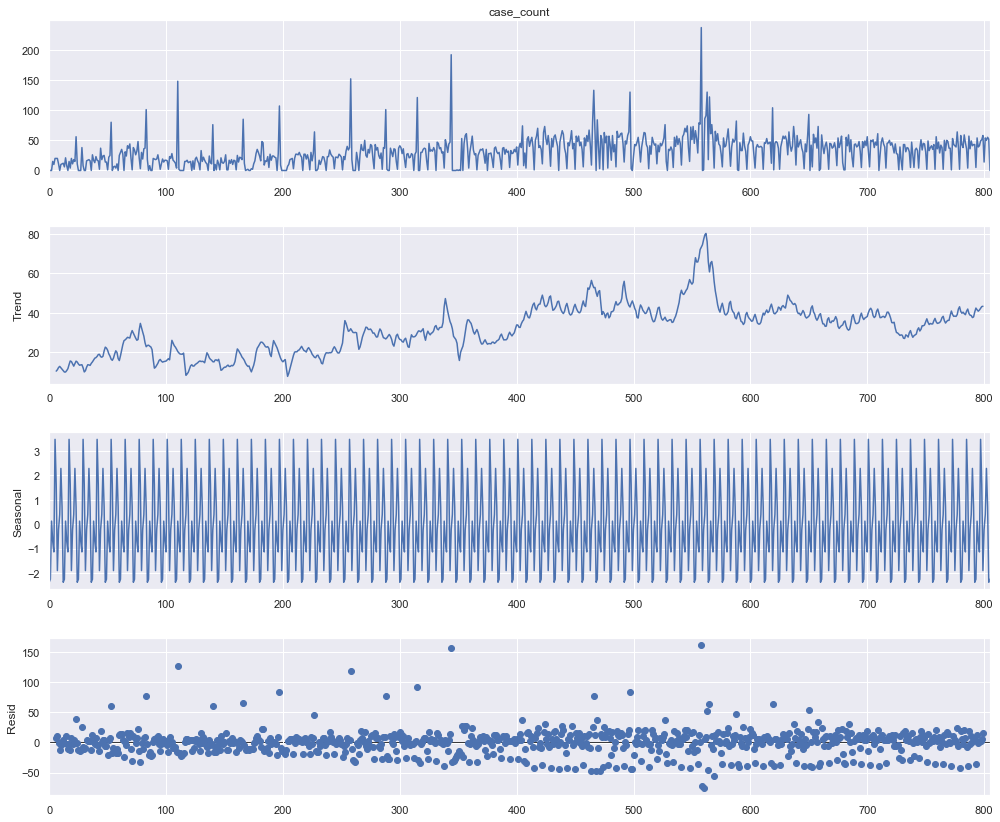

In [19]:
#Decompose the time series data for Segment One:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(StateBranch_df.case_count, model = 'additive', period=12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [20]:
# function for rolling mean and std deviation.
def GetRollingStatistics(StateData_df):
    #Determing rolling statistics
    rolmean = StateData_df.case_count.rolling(12).mean()
    rolstd = StateData_df.case_count.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,8))
    orig = plt.plot(StateData_df.case_count, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation For SegmentOne')
    plt.show()

<h4> Checking ACF and PACF plots

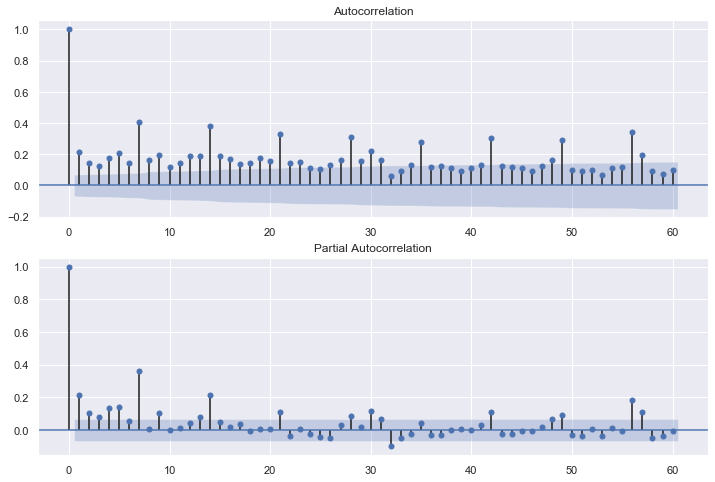

In [21]:
#Plotting ACF, PACF plot  - Differenced data SegmentOne
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(StateBranch_df.case_count, lags=60, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = plot_pacf(StateBranch_df.case_count, lags=60, ax=ax2)# 

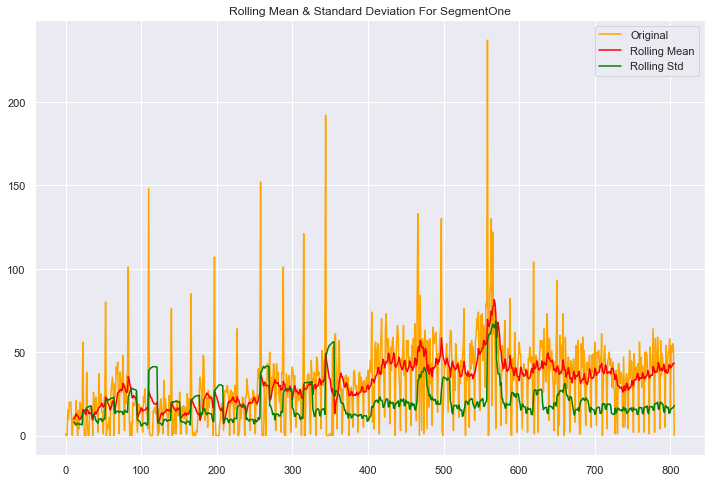

In [22]:
GetRollingStatistics(StateBranch_df)

<b>Augmented Dickey-Fuller Test:</b> This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

#Custom Stationary Test:
def GetCustomStationaryTestResult(_dataframe):
    X = _dataframe.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")
    

#Manual Dicky fuller calculation.     
def ManualAdfullerTest(_dataframe):
    df = pd.DataFrame()
    df["Diff_Value"] = _dataframe.diff()
    diff_values = df["Diff_Value"].values
    Y = diff_values[~np.isnan(diff_values)]
    ts_values_orig = _dataframe.values
    ts_values = ts_values_orig[:-1]
    X = sm.add_constant(ts_values)
    OLS_Model = sm.OLS(Y,X)
    results = OLS_Model.fit()
    print(results.summary())
    print(results.tvalues[1])

In [24]:
#Testing for stationarity.
GetCustomStationaryTestResult(StateBranch_df.case_count)

ADF Statistic: -2.461987
p-value: 0.124999
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


#### BOX PLOT:

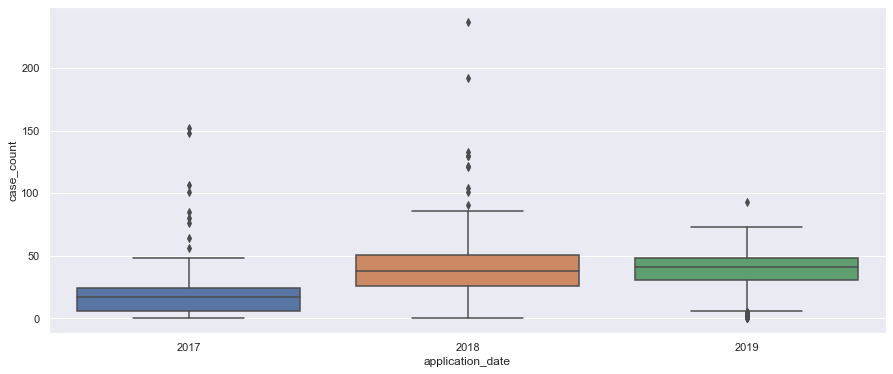

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(StateBranch_df.application_date.dt.year, StateBranch_df.case_count, ax=ax)

<h4> Since the data is not stationary, we do differencing to make it stationary.

In [26]:
StateBranchDiff_df = copy.deepcopy(StateBranch_df)

In [27]:
# difference dataset
def GetDifferencedData(data, interval):
    return [int(data[i]) - int(data[i - interval]) for i in range(interval, len(data))]


def GetInvert_differencedData(orig_data, diff_data, interval):
    inverseTData = [int(diff_data[i-interval]) + int(orig_data[i-interval]) for i in range(interval, len(orig_data))]
    return inverseTData

In [28]:
#Doing first order difference to make the data stationary.
StateBranchDiff_df = GetDifferencedData(StateBranch_df.case_count,1)
StateBranchDiff_df = pd.DataFrame(StateBranchDiff_df)

In [29]:
# Testing for stationarity.
GetCustomStationaryTestResult(StateBranchDiff_df)

ADF Statistic: -10.761926
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Reject Ho - Time Series is Stationary


In [30]:
StateBranchDiff_df=StateBranchDiff_df.rename(columns={0: "case_count"})

In [31]:
StateBranchDiff_df.head()

,case_count
0,-1
1,0
2,15
3,-5
4,10


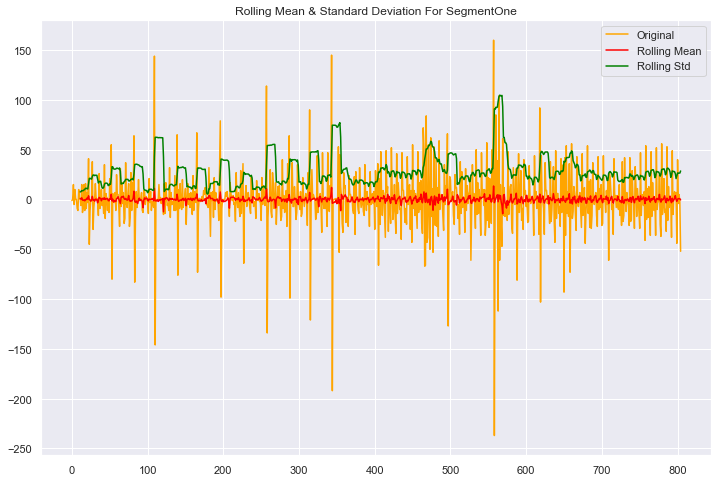

In [32]:
GetRollingStatistics(StateBranchDiff_df)

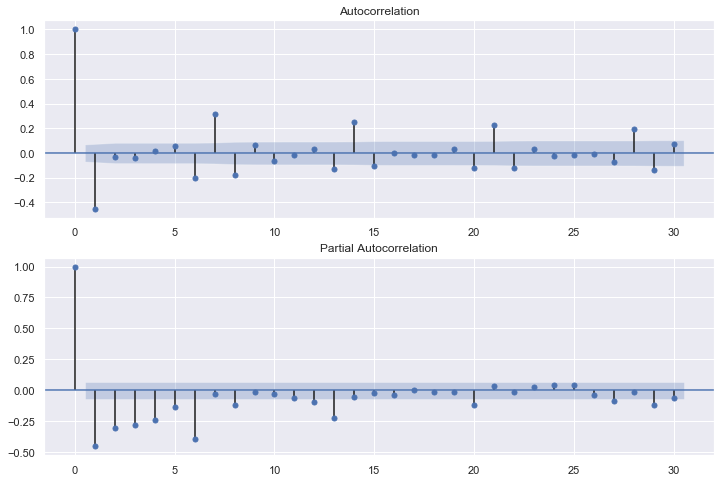

In [33]:
#Plotting ACF, PACF plot  - Differenced data.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(StateBranchDiff_df, lags=30, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = plot_pacf(StateBranchDiff_df, lags=30, ax=ax2)# 

<h3>AR(P)

In [34]:
# fit model
AR_Model = AR(StateBranchDiff_df.case_count).fit()

C:\Users\Navin\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


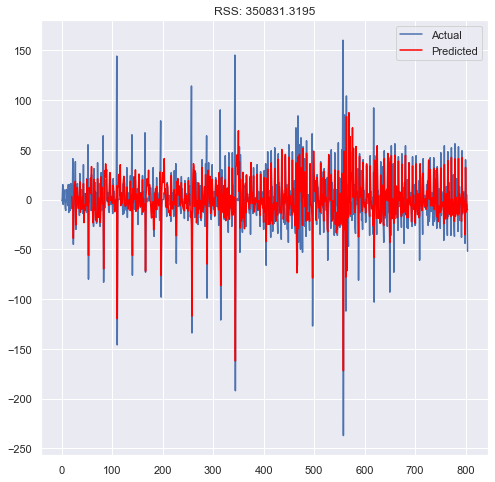

In [35]:
plt.plot(StateBranchDiff_df.case_count)
plt.plot(AR_Model.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((AR_Model.fittedvalues-StateBranchDiff_df.case_count)**2))
# plt.legend('best')
plt.legend({'Actual','Predicted'})
plt.show()

#### Train Test split

In [36]:
#Train Test split
train_data = StateBranchDiff_df[:int(0.75*(len(StateBranchDiff_df)))]
validation_data = StateBranchDiff_df[int(0.75*(len(StateBranchDiff_df))):]

<h3>AUTO ARIMA

In [37]:
# Training AUTO ARIMA
from pmdarima.arima import auto_arima
AutoArima_Model = auto_arima(train_data.case_count,start_p=1, start_q=1,test='adf',max_p=3, max_q=3, m=52,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
AutoArima_Model.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,52) [intercept=True]; AIC=5405.843, BIC=5427.392, Time=41.903 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=6293.313, BIC=6301.933, Time=1.212 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=5905.477, BIC=5922.717, Time=15.120 seconds
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=5522.131, BIC=5539.370, Time=28.441 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=6291.316, BIC=6295.626, Time=1.073 seconds
Fit ARIMA(1,1,1)x(0,1,0,52) [intercept=True]; AIC=5623.469, BIC=5640.709, Time=4.580 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,1,1)x(1,1,1,52) [intercept=True]; AIC=5407.633, BIC=5433.493, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  603
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -2597.081
Date:                              Fri, 15 May 2020   AIC                           5204.163
Time:                                      09:30:57   BIC                           5225.712
Sample:                                           0   HQIC                          5212.584
                                              - 603                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.621      0.534      -0.001       0.000
ma.L1         -1.9702      0.033    -59.969      0.000      -2.035      -1.906
ma.L2          0.9703      0.031     30.905      0.000       0.909       1.032
ma.S.L52      -1.0000      0.051    -19.731      0.000      -1.099      -0.901
sigma2       567.8745   8.93e-05   6.36e+06      0.000     567.874     567.875
===================================================================================
Ljung-Box (Q):                      131.77   Jarque-Bera (JB):              3213.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.56e+22. Standard errors may be unstable.
"""

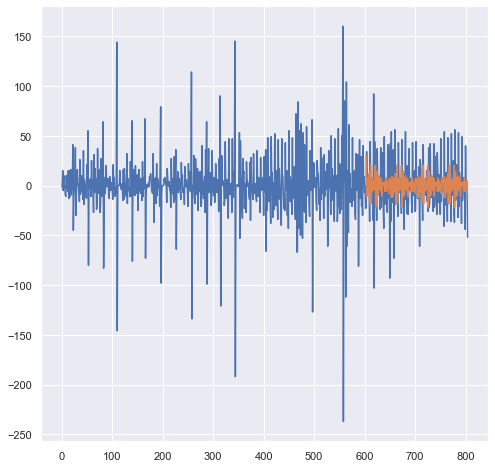

In [38]:
forecast = AutoArima_Model.predict(n_periods=len(validation_data.case_count))
forecast = pd.DataFrame(forecast,index = validation_data.index,columns=['case_count'])

#plot the predictions for validation set
plt.plot(StateBranchDiff_df.case_count, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='case_count')
plt.show()

####  AUTO ARIMA was not capturing the seasonality properly so proceeded with the next model.

<h2> SARIMA

#### Analysing ACF and PACF plot for determing non-seasonal & Seasonal P,D,Q

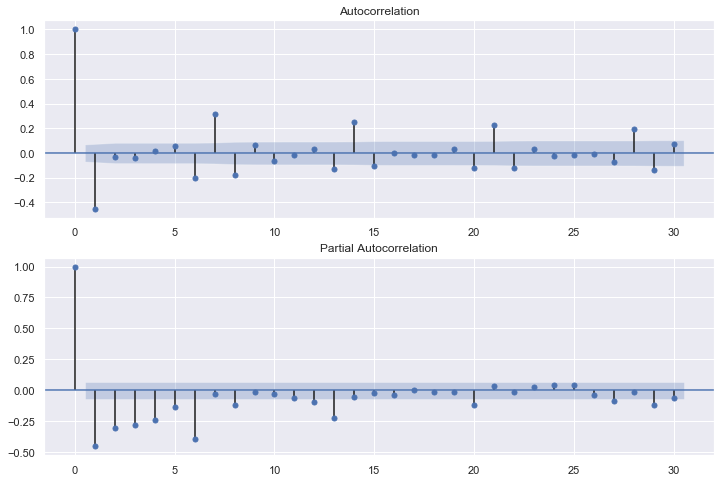

In [39]:
#Plotting ACF, PACF plot  - Differenced data SegmentOne
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(StateBranchDiff_df.case_count, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = plot_pacf(StateBranchDiff_df.case_count, ax=ax2)# 

In [40]:
# Traing SARIMA model with train data.
Sarima_Model = SARIMAX(train_data.case_count, order=(1,1,1), seasonal_order=(2,1,3,52))
Sarima_Model = Sarima_Model.fit(disp=False)

C:\Users\Navin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Navin\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
start_index = validation_data.index.min()
end_index = validation_data.index.max()

#Predictions
SarimaPredictions = Sarima_Model.predict(start=start_index, end=end_index)

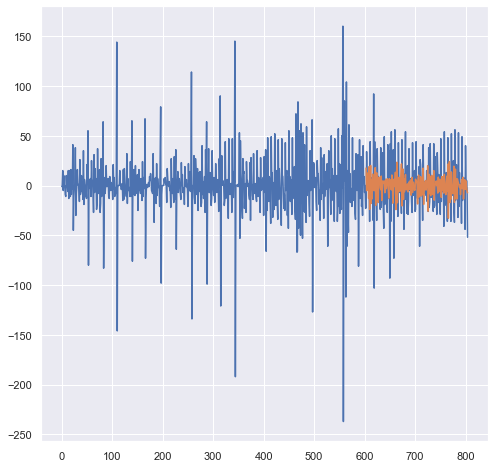

In [42]:
plt.plot(StateBranchDiff_df.case_count)
plt.plot(SarimaPredictions)
# plt.title('RMSE: %.4f'% rmse)

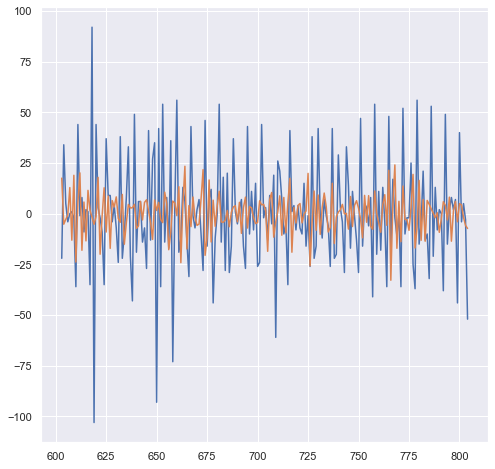

In [43]:
plt.plot(validation_data.case_count)
plt.plot(SarimaPredictions)
# plt.title('RMSE: %.4f'% rmse)

#### Evaluation of SARIMA Model:

In [44]:
SARIMA_MAE = median_absolute_error(validation_data.case_count,SarimaPredictions)

In [45]:
print("The MAE for SARIMA prediction is : ",SARIMA_MAE)

The MAE for SARIMA prediction is :  17.28215104843433


#### Inverse trainform the predictions.

Since the data which is used for prediction is differenced, we inverse it to get the actual value.

In [46]:
#Train Test split of original data for get the actial value back.
Orig_train_data = StateBranch_df[:int(0.75*(len(StateBranch_df)))]
Orig_validation_data = StateBranch_df[int(0.75*(len(StateBranch_df))):]

In [47]:
finalPredictions = pd.DataFrame(SarimaPredictions)
finalPredictions.reset_index(inplace=True)
del finalPredictions['index']
finalPredictions = finalPredictions.rename(columns={0:"case_count"})
finalPredictions.head()

,case_count
0,17.542747
1,-5.183049
2,-2.794220
3,-0.627168
4,12.888351


In [48]:
Orig_validation_data.reset_index(inplace=True)
del Orig_validation_data['index']
Orig_validation_data.head()

,application_date,case_count
0,2018-12-16,4
1,2018-12-17,38
2,2018-12-18,43
3,2018-12-19,39
4,2018-12-20,39


In [50]:
## Inverse differencing:
inversedPrediction = GetInvert_differencedData(Orig_validation_data.case_count,finalPredictions.case_count,1)
print(Orig_validation_data.case_count[0:10])
print('------------------------------------------------------------')
print(inversedPrediction[0:10])

0     4
1    38
2    43
3    39
4    39
5    40
6    38
7     2
8    46
9    45
Name: case_count, dtype: uint16
------------------------------------------------------------
[21, 33, 41, 39, 51, 27, 56, -21, 51, 65]


#### Plotting actual values & inverse of differenced values.

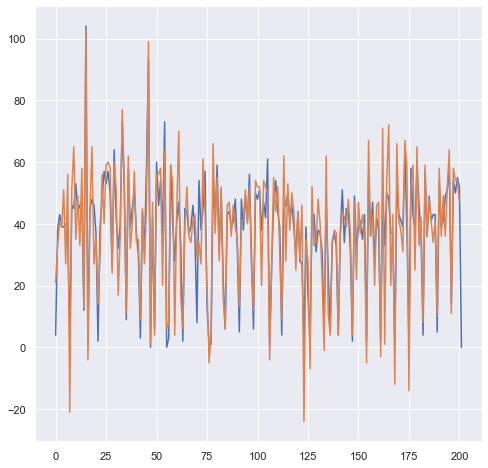

In [51]:
plt.plot(Orig_validation_data.case_count)
plt.plot(inversedPrediction)

## FB-PROPHET

##### Retrieving the original dataframe before differencing. We continue with old dataframe because prophet can handle non stationary data.

In [52]:
StateBranch_df.head()

,application_date,case_count
0,2017-04-01,1
1,2017-04-03,0
2,2017-04-04,0
3,2017-04-05,15
4,2017-04-07,10


In [53]:
# checking for stationarity.
GetCustomStationaryTestResult(StateBranch_df.case_count)

ADF Statistic: -2.461987
p-value: 0.124999
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [54]:
# Renaming the column names to prophet required column names.
# DateStamp and Target column name must be converted into 'ds' and 'y' respectively.

Prophet_Train_fb = StateBranch_df[["application_date","case_count"]]
Prophet_Train_fb = Prophet_Train_fb.rename(columns={"application_date": "ds", "case_count": "y"})

In [55]:
Prophet_Train_fb.tail()

,ds,y
801,2019-07-01,54
802,2019-07-02,50
803,2019-07-03,55
804,2019-07-04,52
805,2019-07-05,0


In [56]:
# Train and Validation split. Train=75%, Test=25%.
train_data = Prophet_Train_fb[:int(0.75*(len(Prophet_Train_fb)))]
validation_data = Prophet_Train_fb[int(0.75*(len(Prophet_Train_fb))):]

In [57]:
#Start and end index
start_index = validation_data.ds.min()
end_index   = validation_data.ds.max()
print(start_index,'----------',end_index)
# Total no.of days to predict.
totalPeriodsToPredict = len(validation_data)

2018-12-16 00:00:00 ---------- 2019-07-05 00:00:00


##### Importing Libraries for FB-PROPHET

In [58]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import holidays

In [59]:
# Getting indian holiday list for year 2017,2018 & 2019.
# prophet by its own will have the default indian holiday list but we are trying to give it externally.
indianHolidays = holidays.IND(years=[2017,2018,2019])

In [60]:
column_names = ["ds", "holiday"]
holidays_df = pd.DataFrame(columns=column_names)
holidayList =[]
nameList =[]
for date,name in indianHolidays.items():
    holidayList.append(date)
    nameList.append(name)
holidays_df['ds'] = holidayList
holidays_df['holiday'] = nameList

In [61]:
holidays_df.head()

,ds,holiday
0,2017-01-14,Makar Sankranti / Pongal
1,2017-01-26,Republic Day
2,2017-08-15,Independence Day
3,2017-10-02,Gandhi Jayanti
4,2017-05-01,Labour Day


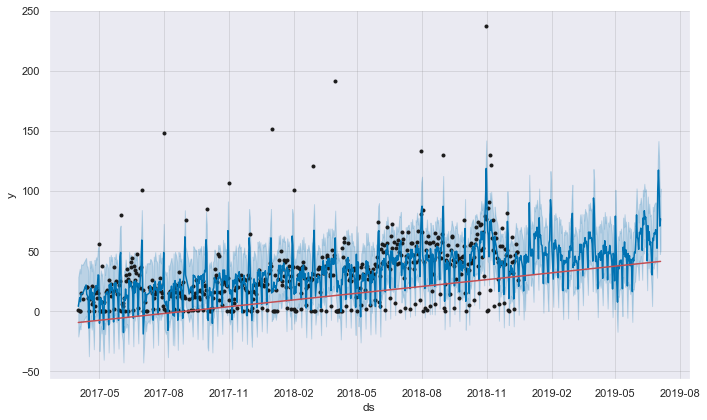

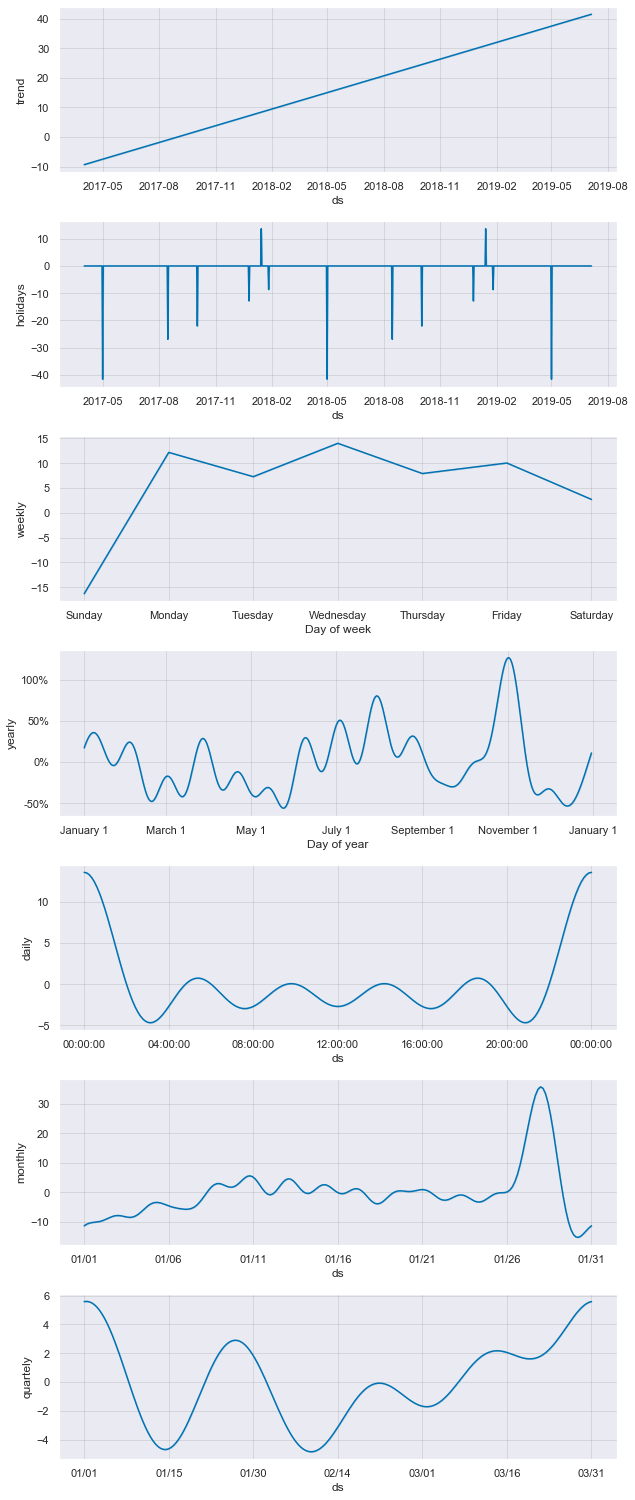

In [62]:
#LINEAR GROWTH
#Disabling default Seasonality and adding them after initialization to get full controle of it.
prophet = Prophet(
        growth='linear',
        # point at which there will be a change in trend.
        changepoints = ['2017-06-06'],
        seasonality_mode='additive',
        # disabling default seasonality.
        daily_seasonality=False,
        yearly_seasonality=False,
        weekly_seasonality=False,
        # providing the indian holiday list.
        holidays=holidays_df,
        # Influence of the holidays on prediction
        holidays_prior_scale=40,
        n_changepoints=50
        ).add_seasonality(
            name='monthly',
            period=30.5,
            # amount of fluctuations monthly seasonality is going to have is determined by fourier_order.
            fourier_order=15,
            # Importance of monthly seasonality is determined by prior_scale.
            prior_scale=5
        ).add_seasonality(
            name='daily',
            period=1,
            # amount of fluctuations daily seasonality is going to have is determined by fourier_order.
            fourier_order=5,
            # Importance of daily seasonality is determined by prior_scale.
            prior_scale=10
        ).add_seasonality(
            name='weekly',
            period=7,
            # amount of fluctuations weekly seasonality is going to have is determined by fourier_order.
            fourier_order=15,
            # Importance of weekly seasonality is determined by prior_scale.
            prior_scale=5,
        ).add_seasonality(
            name='yearly',
            period=365.25,
            # amount of fluctuations yearly seasonality is going to have is determined by fourier_order.
            fourier_order=15,
            # Importance of yearly seasonality is determined by prior_scale.
            prior_scale=5,
            mode='multiplicative'
        ).add_seasonality(
            name='quartely',
            period=356.25/4,
            # amount of fluctuations quartely seasonality is going to have is determined by fourier_order.
            fourier_order=5,
            # Importance of quartely seasonality is determined by prior_scale.
            prior_scale=15
        )

prophet.add_country_holidays(country_name='IND')
# prophet.fit(Prophet_Train_fb[Prophet_Train_fb['ds'] < pd.to_datetime('2018-12-16')])
prophet.fit(train_data)

# Prediction for next determined days
future = prophet.make_future_dataframe(periods = totalPeriodsToPredict, freq='D')
# Actual prediction.
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
# graph plot
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

In [63]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Gandhi Jayanti,...,quartely,quartely_lower,quartely_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2017-04-01,-9.347082,-20.990923,28.564875,-9.347082,-9.347082,0.0,0.0,0.0,0.0,...,5.556825,5.556825,5.556825,2.706439,2.706439,2.706439,0.116575,0.116575,0.116575,4.106920
1,2017-04-03,-9.223844,-12.404380,35.384763,-9.223844,-9.223844,0.0,0.0,0.0,0.0,...,4.834995,4.834995,4.834995,12.175446,12.175446,12.175446,-0.018684,-0.018684,-0.018684,11.260830
2,2017-04-04,-9.162225,-14.998705,31.373719,-9.162225,-9.162225,0.0,0.0,0.0,0.0,...,4.134598,4.134598,4.134598,7.284183,7.284183,7.284183,-0.087913,-0.087913,-0.087913,7.963250
3,2017-04-05,-9.100605,-7.973873,39.157178,-9.100605,-9.100605,0.0,0.0,0.0,0.0,...,3.238286,3.238286,3.238286,14.006875,14.006875,14.006875,-0.153594,-0.153594,-0.153594,14.748429
4,2017-04-07,-8.977367,-9.102661,38.498188,-8.977367,-8.977367,0.0,0.0,0.0,0.0,...,1.037336,1.037336,1.037336,10.037727,10.037727,10.037727,-0.262410,-0.262410,-0.262410,14.490772


#### Evaluation of Train data:

In [64]:
trainForecast =  forecast[forecast['ds'] < pd.to_datetime('2018-12-16')]

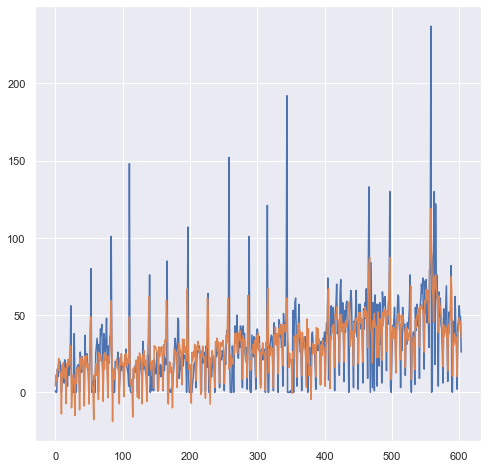

In [65]:
plt.plot(train_data.y)
plt.plot(trainForecast.yhat)

In [66]:
Train_MAE = mean_absolute_error(train_data.y,trainForecast.yhat)
print("The MAE for Train data is : ",Train_MAE)

The MAE for Train data is :  11.27320100970553


#### Evaluation of Validation data:

In [68]:
testForecast =  forecast[forecast['ds'] >= pd.to_datetime('2018-12-16')]

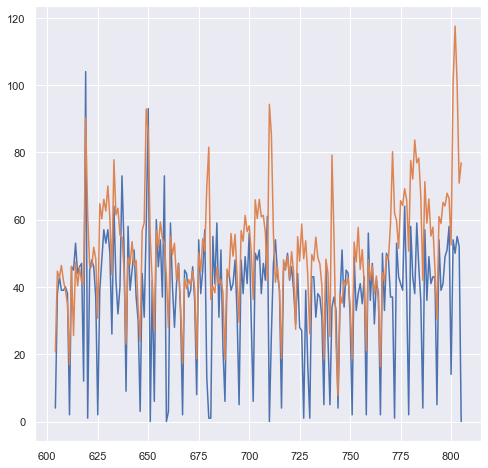

In [69]:
plt.plot(validation_data.y)
plt.plot(testForecast.yhat)

In [70]:
Validation_MAE = mean_absolute_error(validation_data.y,testForecast.yhat)
print("The MAE for validation data is : ",Validation_MAE)

The MAE for validation data is :  15.851056341945506


### On comparing all above predictions, MAE was less in FB-PROPHET which game around 11% for train and 15% validation.